In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski
import skimage.io
import skimage.transform
from scipy.fft import dct,idct,dctn,idctn
from scipy.sparse import spdiags


Load in the image and down sample it so that CVXPY can solve the problem in a reasonable amount of time.

Original size:  (374, 266)
Rescaled size:  (37, 27)


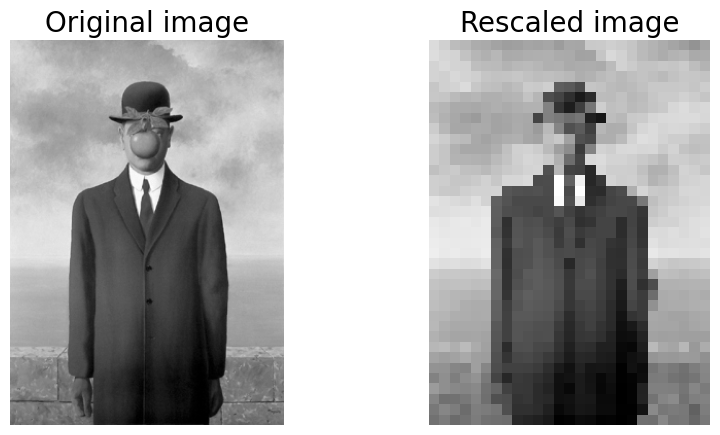

In [3]:
DOWNSAMPLE_RATE = 0.1
img_path = 'SonOfMan.jpg'
# read image
img_full = ski.io.imread(img_path)
# convert to grayscale and visualize 
img_full = ski.color.rgb2gray(img_full)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img_full, cmap='gray')
ax[0].set_title("Original image", fontsize= 20)
ax[0].axis('off')
print("Original size: ", img_full.shape)
# resize image 
img = ski.transform.rescale(img_full, DOWNSAMPLE_RATE, anti_aliasing=False)
print("Rescaled size: ", img.shape)
ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image", fontsize= 20)
ax[1].axis('off')
plt.show()

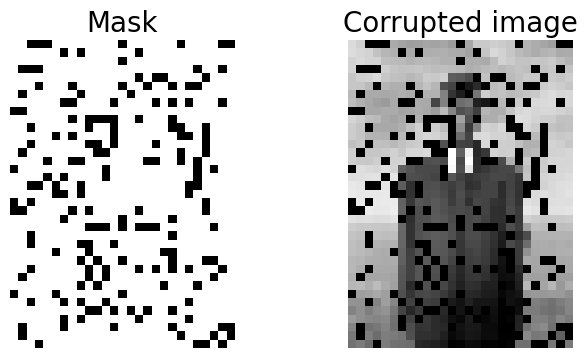

In [4]:
Ny, Nx = img.shape
mask_prop = 0.2
np.random.seed(515)
obs_indices = np.random.choice(Nx*Ny,int(mask_prop*Nx*Ny))
mask = np.ones(Ny*Nx)
mask[obs_indices]=0.
mask = mask.reshape(Ny,Nx)
masked_img = mask * img

fig, ax = plt.subplots(1,2 , figsize=(8, 4))
ax[0].imshow(mask, cmap = 'gray')
ax[0].set_title('Mask', fontsize= 20)
ax[0].axis('off')
ax[1].imshow(mask*img, cmap = 'gray')
ax[1].set_title('Corrupted image', fontsize= 20)
ax[1].axis('off')
plt.show()

In [5]:
def construct_DCT_Mat( Ny, Nx ):
  Dx = dct(np.eye(Nx), axis =0, norm='ortho')
  Dy = dct(np.eye(Ny), axis = 0, norm='ortho')
  A = np.kron(Dy, Dx)
  return A
# construct inverse DCT matrix
def construct_iDCT_Mat( Ny, Nx ):
  Dx = idct(np.eye(Nx), axis =0, norm='ortho')
  Dy = idct(np.eye(Ny), axis = 0, norm = 'ortho')
  invA = np.kron(Dy, Dx)
  return invA

# Dmask = ...
Ny, Nx = img.shape
dctMat = construct_DCT_Mat(Ny,Nx)
inv_dctMat = construct_iDCT_Mat(Ny,Nx)

## Compute the solution using CVXPY

Perform Task 2 in the Homework by writing down the "flattened" version of the optimization problem (2) and solve it using CVXPY. 

In [9]:
lmda = 0.01
x = cvx.Variable(Ny*Nx)
y = img.flatten()
A = dctMat
Ainv = inv_dctMat
mask_vec = mask.flatten()
D = spdiags(mask_vec, 0, mask_vec.size, mask_vec.size)
objective = cvx.Minimize(0.5 * cvx.norm(D @ ((Ainv @ x) - y))**2 + lmda*cvx.norm(x,1))
prob = cvx.Problem(objective)
prob.solve()

print(prob.status)

sol = x.value

optimal


## Evaluate the reconstruction here
We calculate mean squared error on the masked out pixels relative to the variance on the original image. Report these values in your report. 

Mean squared error: 0.047985717502810527


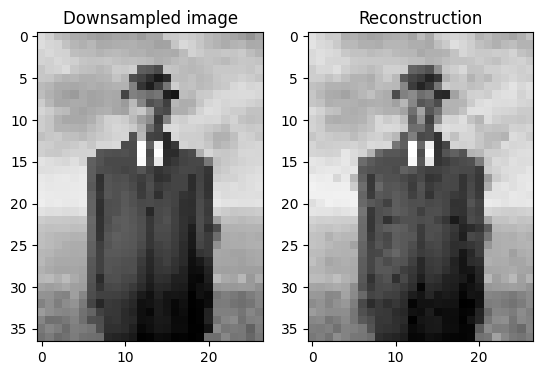

In [10]:
reconstruction = idctn(sol.reshape(Ny,Nx),norm = 'ortho')
relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("Downsampled image")
plt.subplot(1,2,2)
plt.imshow(reconstruction,cmap ='gray')
plt.title("Reconstruction")
plt.show()

Side note, unrelated to your HW: 

using CVXPY this way is really not a great idea since:
1. We're materializing DCT matrices, which makes calculations expensive. 
2. We're instantiating (large+dense) Kronecker product matrices, these are precisely the A and invA matrices. 

Often, however, for smaller problems (and much harder problems), CVXPY can work incredibly well!
We downsampled the problem a lot so that it'll run quickly, but if you try increasing the resolution by a bit, it'll start taking much much longer. For example, try increasing the DOWNSAMPLE_RATE to 0.2 and you'll see cvxpy slows down a lot. 

Again, You don't need to report this in your report. 

## Implement your own Proximal Gradient Descent

In order to write a fast implementation, you should avoid instantiating matrices whenever possible and just apply the DCT and iDCT functions from Scipy, i.e., scipy.fft.dctn and scipy.fft.idctn may be useful!

In [ ]:
def build_objective_components(mask,masked_image,lam):
    def f(x):
        pass

    def gradf(x):
        pass

    def L1(x):
        pass

    def proxL1(x,t):
        pass
    return f,gradf,L1,proxL1

def PGD_solve(x0,f,gradf,h,proxh,max_iter =5000,tol = 1e-4):
    pass

First apply your code to the down sampled image and compare to the CVXPY solution to make sure it is working. Report the relative MSE as before.

In [ ]:
sol_pgd = ...
reconstruction = ...

relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("Downsampled image")
plt.subplot(1,2,2)
plt.imshow(reconstruction,cmap ='gray')
plt.title("Reconstruction")
plt.show()

## Now rerun on the full size image with more masking
This should still be pretty fast if you implemented the PGD correctly using the scipy functions. 

In [ ]:
# resize image 
img = ski.transform.rescale(img_full, 1., anti_aliasing=False)
Ny, Nx = img.shape
mask_prop = 0.6
mask_indices = np.random.choice(Nx*Ny,int(mask_prop*Nx*Ny),replace = False)
mask = np.ones(Ny*Nx)
mask[mask_indices]=0.
mask = mask.reshape(Ny,Nx)
masked_img = mask * img
print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image", fontsize= 20)
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1,2 , figsize=(8, 3))
ax[0].imshow(mask, cmap = 'gray')
ax[0].set_title('Mask', fontsize= 20)
ax[0].axis('off')
ax[1].imshow(mask*img, cmap = 'gray')
ax[1].set_title('Corrupted image', fontsize= 20)
ax[1].axis('off')
plt.show()

Present a figure comparing the original, corrupted, and recovered images using your algorithm. Also compute the relative MSE of the recovered image and include it in the report. 

In [ ]:
sol_pgd = ...
reconstruction = ...

relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("Downsampled image")
plt.subplot(1,2,2)
plt.imshow(reconstruction,cmap ='gray')
plt.title("Reconstruction")
plt.show()